# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: Cemex, Grupo Carso y Grupo Financiero Banorte.

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [20]:
# Importar librerías
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline 

In [21]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [22]:
# Descargar precios y graficar
tickers= ['CEMEXCPO.MX','GCARSOA1.MX','GFNORTEO.MX']
start_date='2015-01-01'
end_date='2020-05-07'
closes=get_adj_closes(tickers,start_date,end_date,'m')

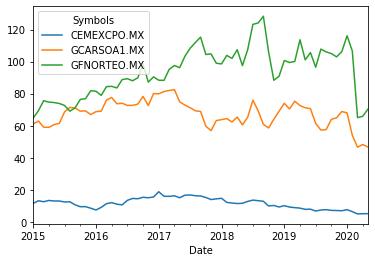

In [23]:
closes.plot()

1.2. A partir de los precios, obtener los rendimientos mensuales:

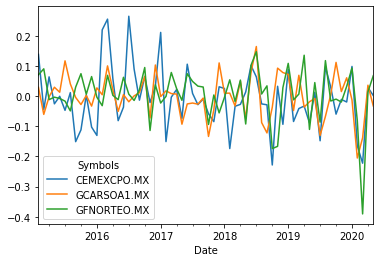

In [24]:
# Obtener rendimientos mensuales y graficar
ret = closes.pct_change().dropna()
ret.plot()

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [25]:
# Resumen: rendimiento medio mensual y volatilidad
summary = pd.DataFrame({'Media':ret.mean(),'Vol':ret.std()})
summary

,Media,Vol
Symbols,,
CEMEXCPO.MX,-0.007656,0.101801
GCARSOA1.MX,-0.001833,0.068633
GFNORTEO.MX,0.005165,0.083071


In [26]:
# Matriz de covarianza
Sigma = ret.cov()
Sigma

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,0.010363,0.002565,0.003240
GCARSOA1.MX,0.002565,0.004711,0.002024
GFNORTEO.MX,0.003240,0.002024,0.006901


In [27]:
# Matriz de correlación
R = ret.corr()
R

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,1.000000,0.367082,0.383107
GCARSOA1.MX,0.367082,1.000000,0.355014
GFNORTEO.MX,0.383107,0.355014,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [28]:
# Tasa libre de riesgo
rf = .057 / 12 
rf

0.00475

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [29]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_port = 100000
n_act = 3

2.1. Generamos los portafolios

In [30]:
# Generar una matriz de pesos de n_port x n_act, tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet(np.array([1, 1, 1]), n_port)
W.shape

(100000, 3)

In [31]:
# Rendimientos y volatilidad de cada portafolios
Ep = summary['Media'].values.T.dot(W.T)
Ep

array([-0.00124654, -0.00070145,  0.00346393, ...,  0.00177547,
       -0.00244819, -0.00193601])

In [33]:
vol = np.zeros((n_port,))
for i in range(n_port):
    vol[i] = (W[i, : ].T.dot(Sigma).dot(W[i, :]))**0.5

In [34]:
vol

array([0.06102693, 0.06140532, 0.07348678, ..., 0.06507475, 0.07547184,
       0.06512831])

In [35]:
# Radio de Sharpe
Rs = (Ep - rf) / vol

In [38]:
# Data frame de resultados
portafolios = pd.DataFrame({'w1': W[:, 0],
                            'w2': W[:, 1],
                            'w3': W[:, 2],
                            'Media': Ep,
                            'Vol': vol,
                            'Rs': Rs})
portafolios.head()

,w1,w2,w3,Media,Vol,Rs
0,0.137160,0.664873,0.197967,-0.001247,0.061027,-0.098261
1,0.061670,0.725278,0.213051,-0.000701,0.061405,-0.088778
2,0.059672,0.133720,0.806608,0.003464,0.073487,-0.017501
3,0.225974,0.195329,0.578697,0.000901,0.067463,-0.057058
4,0.471459,0.156782,0.371760,-0.001977,0.071581,-0.093974


2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [39]:
# Portafolio EMV
EMV = portafolios.loc[portafolios['Rs'].idxmax()]
EMV

w1       0.000632
w2       0.001826
w3       0.997543
Media    0.005144
Vol      0.082936
Rs       0.004749
Name: 98519, dtype: float64

In [40]:
# Portafolio mínima varianza
minvar = portafolios.loc[portafolios['Vol'].idxmin()]
minvar

w1       0.112402
w2       0.582665
w3       0.304933
Media   -0.000354
Vol      0.060408
Rs      -0.084490
Name: 11317, dtype: float64

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

Text(0.5, 0, 'Rendimiento esperado')

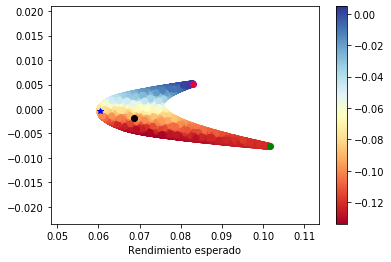

In [43]:
# Gráfica
plt.figure(figsize=(6, 4))
plt.scatter(portafolios['Vol'],portafolios['Media'], c=portafolios['Rs'],cmap='RdYlBu')
plt.colorbar()
plt.plot(summary.loc['CEMEXCPO.MX','Vol'], summary.loc['CEMEXCPO.MX', 'Media'], 'og')
plt.plot(summary.loc['GCARSOA1.MX','Vol'], summary.loc['GCARSOA1.MX', 'Media'], 'ok')
plt.plot(summary.loc['GFNORTEO.MX','Vol'], summary.loc['GFNORTEO.MX', 'Media'], 'om')
# EMV
plt.plot(EMV['Vol'],EMV['Media'],'*r')
# Min var
plt.plot(minvar['Vol'],minvar['Media'],'*b')

plt.xlabel('Volatilidad')
plt.xlabel('Rendimiento esperado')

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [44]:
# Importamos funcion minimize del modulo optimize de scipy
from scipy.optimize import minimize

In [46]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
# Sigma 
# 2. Eind: rendimientos esperados activos individuales
Eind = summary['Media'].values
Eind

array([-0.00765564, -0.00183334,  0.00516472])

In [47]:
Sigma

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,0.010363,0.002565,0.003240
GCARSOA1.MX,0.002565,0.004711,0.002024
GFNORTEO.MX,0.003240,0.002024,0.006901


In [49]:
# Función objetivo
def menos_RS(w, Sigma, Eind, rf):
    Ep = Eind.T.dot(w)
    vol = (w.T.dot(Sigma).dot(w))**0.5
    RS = (Ep - rf) / rf
    return -RS

In [51]:
# Dato inicial
w0 = np.ones((n_act, )) / n_act
# Cotas de las variables
bnds =((0, None),)*n_act
# Restricciones
cons ={'type':'eq','fun': lambda w: w.sum() - 1}

In [57]:
# Portafolio EMV
resultados = minimize(fun=menos_RS, x0=w0, args=(Sigma, Eind, rf), bounds=bnds, constraints=cons)
resultados 

     fun: -0.08730909014691475
     jac: array([ 1.61171273,  0.3859654 , -1.08730909])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([7.77156117e-16, 0.00000000e+00, 1.00000000e+00])

In [56]:
# Comparar
w_EMV = resultados.x
w_EMV

array([7.77156117e-16, 0.00000000e+00, 1.00000000e+00])

In [58]:
EMV

w1       0.000632
w2       0.001826
w3       0.997543
Media    0.005144
Vol      0.082936
Rs       0.004749
Name: 98519, dtype: float64

3.2. Portafolio EMV

In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio EMV


In [ ]:
# Comparar


# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios normalizados.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

## Esto lo usarán en la actividad en conjunto con las demás herramientas vistas en el módulo 3 (LAC, distribución óptima de capital).

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>